In [1]:
# import sys
# sys.path.insert(1, "/Users/ischoning/PycharmProjects/eyeMovements/eventdetect-master")
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import matplotlib.transforms as mtransforms
import viterbi
import baum_welch
from scipy.interpolate import make_interp_spline, BSpline

13086
#subject_id                   int64
display_refresh_rate          int64
eyetracker_model             object
dot_deg_sz                  float64
eyetracker_sampling_rate    float64
eyetracker_mode              object
fix_stim_center_size_pix      int64
operator                     object
et_model                     object
display_width_pix             int64
display_height_pix            int64
exp_date                     object
screen_width                float64
screen_height               float64
eye_distance                float64
SESSION_ID                    int64
trial_id                      int64
TRIAL_START                 float64
TRIAL_END                   float64
posx                        float64
posy                        float64
dt                          float64
ROW_INDEX                     int64
BLOCK                        object
session_id                    int64
device_time                 float64
time                        float64
left_gaze_x           

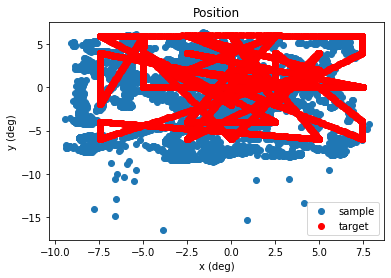

In [2]:
# files
file = '/Users/ischoning/PycharmProjects/GitHub/data/varjo_events_3_0_0.txt'

# create dataframe
df = pd.read_csv(file, sep="\t")

print(len(df))
# print(df.columns.values)
print(df.dtypes)
print(df.time.head())
print(df.dt.head())
print(df.device_time.head()) # same as time

# sample rate: 100 samples per sec
df = df[:]

plt.scatter(df.right_angle_x, df.right_angle_y, label = 'sample')
plt.scatter(df.target_angle_x, df.target_angle_y, color = 'red', label = 'target')
plt.title('Position')
plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.legend()
plt.show()

In [3]:
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

In [4]:
del_x_r = np.diff(df.right_angle_x, prepend=0)
del_y_r = np.diff(df.right_angle_y, prepend=0)
df['d_r'] = np.sqrt(del_x_r**2 + del_y_r**2)

del_x_l = np.diff(df.left_angle_x, prepend=0)
del_y_l = np.diff(df.left_angle_y, prepend=0)
df['d_l'] = np.sqrt(del_x_l**2 + del_y_l**2)

df['isi'] = np.diff(df.time, prepend = 0)
print(df.isi.head())

df['vel_r'] = df.d_r/df.isi
df['vel_l'] = df.d_l/df.isi

del_vel_r = np.diff(df.vel_r, prepend=0)
del_vel_l = np.diff(df.vel_l, prepend=0)

df['accel_r'] = del_vel_r/df.isi
df['accel_l'] = del_vel_l/df.isi

del_accel_r = np.diff(df.accel_r, prepend=0)
del_accel_l = np.diff(df.accel_l, prepend=0)

df['jolt_r'] = del_accel_r/df.isi
df['jolt_l'] = del_accel_l/df.isi

# remove the first three datapoints (due to intersample calculations)
df = df[3:]
df.reset_index(drop=True, inplace=True)

0    8.568000
1    0.010000
2    0.010000
3    0.009999
4    0.010000
Name: isi, dtype: float64


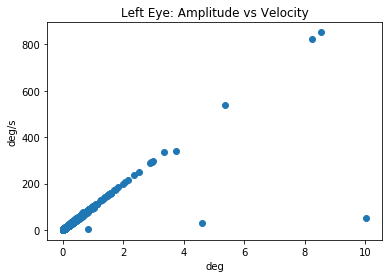

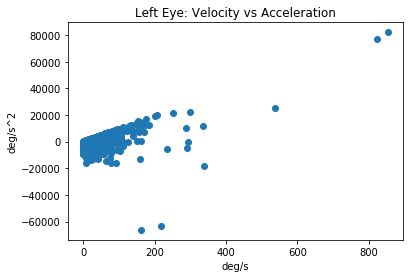

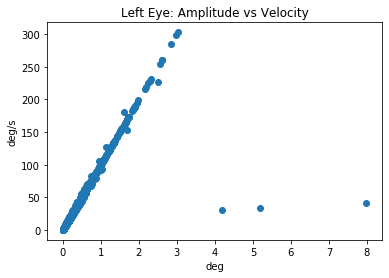

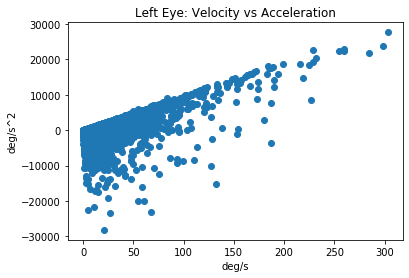

In [5]:
# left eye
plt.scatter(df.d_l, df.vel_l)
#plt.plot(df.d_l, 21 + 2.2*df.d_l, label = 'Carpenters Thm: D = 21 + 2.2*A')
plt.title('Left Eye: Amplitude vs Velocity')
plt.xlabel('deg')
plt.ylabel('deg/s')
plt.show()
plt.scatter(df.vel_l, df.accel_l)
plt.title('Left Eye: Velocity vs Acceleration')
plt.xlabel('deg/s')
plt.ylabel('deg/s^2')
plt.show()

# right eye
plt.scatter(df.d_r, df.vel_r)
#plt.plot(df.d_r, 21 + 2.2*df.d_r, label = 'Carpenters Thm: D = 21 + 2.2*A')
plt.title('Left Eye: Amplitude vs Velocity')
plt.xlabel('deg')
plt.ylabel('deg/s')
plt.show()
plt.scatter(df.vel_r, df.accel_r)
plt.title('Left Eye: Velocity vs Acceleration')
plt.xlabel('deg/s')
plt.ylabel('deg/s^2')
plt.show()

In [ ]:
# prep for correlation between pupil sizes (left and right)
corr_df = pd.DataFrame((df.left_pupil_measure1, df.right_pupil_measure1))
pe_corr = corr_df.corr('pearson')
sp_corr = corr_df.corr('spearman')
print(pe_corr)
print(sp_corr)

# prep for correlation between amplitude and veloctiy
corr_df = pd.DataFrame((df.d_r, df.vel_r)) 
pe_corr = corr_df.corr('pearson')
sp_corr = corr_df.corr('spearman')
print(pe_corr)
print(sp_corr)

In [ ]:

print(np.sum(np.where(df.left_pupil_measure1 == 0)))
print(np.sum(np.where(df.right_pupil_measure1 == 0)))
print(np.sum(np.where(df.vel_l == 0)))
print(np.sum(np.where(df.vel_r == 0)))
print('-------------')
print('Correlation:')
# scores are between -1 and 1 for perfectly negatively correlated variables and
# perfectly positively correlated respectively (+- 0.5 is good threshold)

# pearson correlation
# Assumes Gaussian distribution of the data.
print(stats.pearsonr(df.d_l, df.vel_l))
print(stats.pearsonr(df.d_r, df.vel_r))
print(stats.pearsonr(df.vel_l, df.accel_l))
print(stats.pearsonr(df.vel_r, df.accel_r))

# spearman correlation (non-parametric rank-based approach)
# does not assume linear relation or gaussian distribution (also monotonic relation assumed)
print(stats.spearmanr(df.d_l, df.vel_l))
print(stats.spearmanr(df.d_r, df.vel_r))
print(stats.spearmanr(df.vel_l, df.accel_l))
print(stats.spearmanr(df.vel_r, df.accel_r))
"""

print('-------------')

bad_data = []
cond_1, cond_2, cond_3, cond_4, cond_5 = 0, 0, 0, 0, 0
for i in range(len(df)):
    d_l = df.d_l[i]
    d_r = df.d_r[i]
    vel_l = df.vel_l[i]
    vel_r = df.vel_r[i]
    accel_l = df.accel_l[i]
    accel_r = df.accel_r[i]
    pupil_l = df.left_pupil_measure1[i]
    pupil_r = df.right_pupil_measure1[i]
    
    print('cond_1:')
    print('    pupil_l:', pupil_l)
    print('    pupil_r:', pupil_r)
    print('cond_2:')
    print('    abs(pupil_l - pupil_r):', abs(pupil_l - pupil_r))
    print('cond_3:')
    print('    vel_l:', vel_l)
    print('    vel_r:', vel_r)
    print('cond_4:')
    print('    abs(vel_l - 21 - 2.2*d_l):', abs(vel_l - 21 - 2.2*d_l))
    print('    abs(vel_r - 21 - 2.2*d_r):', abs(vel_r - 21 - 2.2*d_r))
    print('cond_5:')
    print('    abs(accel_l - 21 - 2.2*vel_l):', abs(accel_l - 21 - 2.2*vel_l))
    print('    abs(accel_r - 21 - 2.2*vel_r):', abs(accel_r - 21 - 2.2*vel_r))
    print('correlation:')
    print('    spearmanr(d_l, vel_l):', stats.spearmanr(d_l, vel_l))
    print('    spearmanr(d_r, vel_r):', stats.spearmanr(d_r, vel_r))
    print('    spearmanr(vel_l, accel_l):', stats.spearmanr(vel_l, accel_l))
    print('    spearmanr(vel_r, accel_r):', stats.spearmanr(vel_r, accel_r))
    
    # no pupil size?
    if pupil_l == 0 or pupil_l == None or pupil_r == 0 or pupil_r == None:
        bad_data.append(i)
        cond_1 += 1
    
    # pupil size correlated?
    elif abs(pupil_l - pupil_r) > 0.01:
        bad_data.append(i)
        cond_2 += 1
    
    # angular velocity greater than 1000 deg/s?
    elif vel_r > 1000 or vel_r == 0 or vel_l > 1000 or vel_l == 0:
        bad_data.append(i)
        cond_3 += 1
    
    # correlation between amplitude of movement and velocity agrees with
    # Carpenter's Theorem: D = 21 + 2.2A where D~deg/ms, A~deg traversed (+- 0.1)
    elif abs(vel_l - 21 - 2.2*d_l) > 1 or abs(vel_r - 21 - 2.2*d_r) > 1:
        bad_data.append(i)
        cond_4 += 1
    
    # changes of direction in velocity during saccade (velocity and acceleration correlated)
    elif abs(accel_l - 21 - 2.2*vel_l) > 1 or abs(accel_r - 21 - 2.2*vel_r) > 1:
        bad_data.append(i)
        cond_5 += 1
        
#df.drop(index = bad_data, inplace = True)
#df.reset_index(drop=True, inplace=True)

print("Number of datapoints with no pupil size:", cond_1)
print("Number of datapoints with uncorrelated pupil sizes:", cond_2)
print("Number of datapoints with intersample velocity equal to zero or greater than 1000 deg/ms:", cond_3)
print("Number of datapoints with no correlation (cov=0?) between displacement and velocity:", cond_4)
print("Number of datapoints with no correlation (cov-0?) between velocity and acceleration:", cond_5)

#df = df.iloc[1:]
"""

In [ ]:
"""
plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.d)
plt.title('Displacement')
plt.xlabel('time (ms)')
plt.ylabel('dispersion (deg)')
plt.show()

plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.vel)
plt.title('Velocity')
plt.xlabel('time (ms)')
plt.ylabel('velocity (deg/s)')
plt.show()

plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
plt.plot(df.time, df.accel)
plt.title('Acceleration')
plt.xlabel('time (ms)')
plt.ylabel('acceleration (deg/s*s)')
plt.show()

fig = plt.figure(figsize=(18, 6)) # In Matplotlib all the diagrams are created at a default size of 6.4 x 4.8 inches.
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter(df.d, df.vel)

# histogram on the right
ax_bottom.hist(df.d, 30, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(df.vel, 30, histtype='stepfilled', orientation='horizontal', color='deeppink')

ax_main.set(title='Amplitude vs Velocity', xlabel ='displacement (deg)', ylabel ='velocity (deg/ms)')
plt.show()
"""